# **Wildfire Analysis Final Report**
#### Saumya Chaudhary, Moulshree Guleria, Niket Pathak, Linda Mansour

In [ ]:
# @title Imported Libraries & Mounted Google Drive
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr, f_oneway
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---
## **Loading in Data**
#### We loaded in the data from a CSV using pandas, keeping only columns relevant to our problem, and dropping the rest. This is our initial cleaning of the data, prior to any EDA. We performed extensive cleaning and analysis of data, but due to colab contraints we are incorporating only the required analysis here.

In [34]:
# reading the orginal data obtained from NIFC dataset
data_fire = pd.read_csv('/content/drive/MyDrive/InFORM_FireOccurrence_Public_5198090990064181980.csv')

In [35]:
data_fire.shape

(969412, 88)

In [36]:
# keep columns are decided on factors like percentage of NAN value
keep_columns = ['OBJECTID', 'Containment Date Time','Control Date Time', 'Incident Size', 'Fire Discovery Date Time', 'FireOutDateTime', 'GACC','Incident Type Category', 'Incident Type Kind', 'Initial Latitude','Initial Longitude', 'Initial Response Date Time','POO Landowner Kind', 'POO State', 'Predominant Fuel Group', 'Fire Cause General']
len(keep_columns)
all_columns = data_fire.columns
for i in all_columns:
  if i not in keep_columns:
    data_fire.drop(i, inplace=True, axis=1)
final_rows = data_fire.shape[0]
final_columns = data_fire.shape[1]
print(f"After first cleaning: {final_rows} rows, {final_columns} columns")


After first cleaning: 969412 rows, 16 columns




---


## **Weather Data Integration**
#### We used the Open-Meteo weather API in conjunction with our partially cleaned wildfire records in order to calculate daily and hourly averages for certain weather parameters, such as wind speed, temperature, and humidity.

In [37]:
# import requests
# from datetime import datetime, timedelta
# wildFireData = pd.read_csv("weather_id_data.csv").iloc[:5]
# url = "https://archive-api.open-meteo.com/v1/archive"
# output_file = "FireWeatherIntegratedData.csv"
# for index, row in wildFireData.iterrows():
#     object_id = row["OBJECTID"]
#     fire_datetime = row["Fire Discovery Date Time"]
#     latitude = row["Initial Latitude"]
#     longitude = row["Initial Longitude"]
#     fire_date_object = datetime.strptime(fire_datetime, "%Y-%m-%d %H:%M:%S")
#     start_date = (fire_date_object - timedelta(hours=24)).strftime("%Y-%m-%d")
#     end_date = fire_date_object.strftime("%Y-%m-%d")
#     params = {
#         "latitude": latitude, "longitude": longitude,
#         "start_date": start_date, "end_date": end_date,
#         "hourly": "relative_humidity_2m,pressure_msl,surface_pressure,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm",
#         "daily": "temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max", "timezone": "GMT" }
#     response = requests.get(url, params=params, timeout=30)
#     if response.status_code == 200:
#         data = response.json()
#         aggregated_data = {
#             "object_id": object_id, "fire_date": fire_datetime, "latitude": latitude, "longitude": longitude  }
#         for key, values in data.get("daily", {}).items():
#             if key != "time":
#                 aggregated_data[f"avg_{key}"] = sum(values) / len(values)
#         for key, values in data.get("hourly", {}).items():
#             if key != "time":
#                 aggregated_data[f"avg_{key}"] = sum(values) / len(values)
#         pd.DataFrame([aggregated_data]).to_csv(output_file, mode='a', index=False, header=not index)
#     else:
#         print(f"Error: Received status code {response.status_code} for OBJECTID {object_id}")



---


## **Exploratory Data Analysis**

#### **1. Converting to Datetime** - This is a simple conversion so that the imported dataset is compatible with pandas' datetime format, and makes analysis of dates and times of wildfires much easier.

In [38]:
data_fire['Containment Date Time'] = pd.to_datetime(data_fire['Containment Date Time'])
data_fire['Control Date Time'] = pd.to_datetime(data_fire['Control Date Time'])
data_fire['Fire Discovery Date Time'] = pd.to_datetime(data_fire['Fire Discovery Date Time'])
data_fire['Initial Response Date Time'] = pd.to_datetime(data_fire['Initial Response Date Time'])
data_fire['FireOutDateTime']  =  pd.to_datetime(data_fire['FireOutDateTime'])

In [39]:
inform = data_fire.copy()

#### **2. Feature Engineering** - New features such as response time and fire duration are calculated, which provides insights into how long a fire incident has lasted.

In [40]:
inform['FireOutDateTime'] = inform['FireOutDateTime'].fillna(inform['Control Date Time'])
inform['Response Time'] = (inform['Initial Response Date Time'] - inform['Fire Discovery Date Time']).dt.total_seconds() / 3600
inform['Fire Duration (hrs)'] = ((inform['FireOutDateTime'] - inform['Fire Discovery Date Time']).dt.total_seconds() / 3600)

In [41]:
inform['Incident Type Category'] = inform['Incident Type Category'].replace({'WF': 'WildFire','RX': 'Prescribed Fire'})

#### **3. Limiting Geography Range** - Removing countries like Canada and Mexico from our analysis since our focus is only on the United States.

In [42]:
other_countries = ['CA-ON', 'MX-SO', 'MX-BN', 'MX-CA', 'MX-CH']
inform = inform[~inform['POO State'].isin(other_countries)]

#### **4. Mapping Fire Causes from Metadata** - Since the metadata provides descriptions for each fire cause code, this step maps fire incidents to their respective causes by applying a mapping function to the Fire Cause General column. The mapping ensures each numeric code is translated into categories like "Nature" or "Equipment" etc., while missing values get categorized as "Unknown."

In [43]:
cause_mapping = {1: 'Natural',2: 'Equipment/vehicles',3: 'Smoking',4: 'Recreation/cultural activities',5: 'Debris/open burning',6: 'Railroad',
                7: 'Incendiary (unlawful)',8: 'Fire Play (minor)',9: 'Miscellaneous/other',10: 'Fireworks',11: 'Power generation/transmission',12: 'Structure'}
def map_fire_cause(code):
    if pd.isna(code):
        return 'Unknown'
    return cause_mapping.get(int(code), 'Unknown')
inform['Fire Cause General'] = inform['Fire Cause General'].apply(map_fire_cause)


#### **5. Map Seasons According to Time of Year** -  Divides the year into four segments and assigns the seasons to each of them using an apply function for our seasonal analysis.

In [44]:
def get_season(date):
    return ('Winter', 'Spring', 'Summer', 'Fall')[(date.month % 12) // 3]

In [45]:
inform['Season'] = inform['Fire Discovery Date Time'].apply(get_season)

In [46]:
inform['GACC'].unique()

array(['RMCC', 'NRCC', 'SACC', 'OSCC', 'SWCC', 'ONCC', 'NWCC', 'EACC',
       'GBCC', 'AICC', nan, 'AKCC'], dtype=object)

In [47]:
inform['POO Landowner Kind'].unique()

array(['Federal', nan, 'Private', 'Other', '#'], dtype=object)

In [48]:
inform['Fire Cause General'].unique()

array(['Unknown', 'Equipment/vehicles', 'Smoking',
       'Incendiary (unlawful)', 'Natural', 'Miscellaneous/other',
       'Debris/open burning', 'Railroad',
       'Recreation/cultural activities', 'Fireworks', 'Structure',
       'Fire Play (minor)', 'Power generation/transmission'], dtype=object)

In [49]:
inform['Season'].value_counts()

,count
Season,
Summer,449339
Spring,258439
Fall,175424
Winter,86202


#### **6. Handling Negative values** - We ensured our data did not include any invalid negative values, such as ones that would be in response time and fire duration, since it is impossible for those values to be negative in reality.

In [50]:
inform= inform[(inform['Response Time'] >= 0) & (inform['Fire Duration (hrs)'] >= 0)]
inform=inform[inform['Response Time']<100]
inform=inform[inform['Fire Duration (hrs)']<10000]

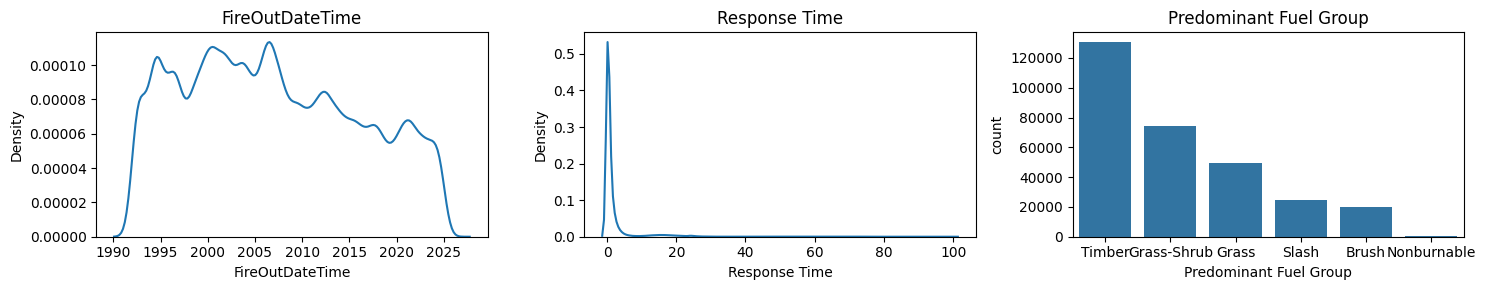

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.kdeplot(inform['FireOutDateTime'], ax=ax[0])
ax[0].set_title('FireOutDateTime')
sns.kdeplot(inform['Response Time'], ax=ax[1])
ax[1].set_title('Response Time')
sns.barplot(x=inform['Predominant Fuel Group'].value_counts().index,
            y=inform['Predominant Fuel Group'].value_counts(), ax=ax[2])
ax[2].set_title('Predominant Fuel Group')
plt.tight_layout()
plt.show()




---


## **Hypotheses**

## **Hypothesis 1 - Relationship between Fuel Group and Incident Size**

One-way ANOVA results (F = 25.08, p < 0.001) indicate significant differences in mean incident size across predominant fuel groups. We reject the null hypothesis, concluding that fuel group influences incident size.  


In [52]:
area_burned = inform.dropna(subset=['Predominant Fuel Group', 'Incident Size'])
area_burned = inform[['Predominant Fuel Group', 'Incident Size']]
area_burned['Predominant Fuel Group'] = area_burned['Predominant Fuel Group'].fillna('Unknown')
area_burned = area_burned.dropna()

fuel_group = area_burned['Predominant Fuel Group'].unique()

grouped_data = [area_burned[area_burned['Predominant Fuel Group'] == group]['Incident Size'] for group in fuel_group]
if all(len(group) > 0 for group in grouped_data):
    # one-way ANOVA
    f_stat, p_value = stats.f_oneway(*grouped_data)
    print("ANOVA F-statistic:", f_stat)
    print("p-value:", p_value)
else:
    print("Some groups are empty; please verify the dataset.")

ANOVA F-statistic: 25.083961619488782
p-value: 6.110925850432983e-30


## **Hypothesis 2 - Relationship between Incident Size and Season**

Chi-Square Test results (χ² = 1338.59, df = 3, p < 0.001) show a significant relationship between incident size categories and seasons. We reject the null hypothesis, concluding that incident size distribution varies significantly by season. The season with the highest incident size is the third season, summer.


In [53]:
hyoptest = inform.copy()
hyoptest =hyoptest[(hyoptest['Incident Size']>=40)& (hyoptest['Incident Size']<=20000) ]
bins = [40, 200,70000]
labels = ['small', 'large']
hyoptest['size_category'] = pd.cut(hyoptest['Incident Size'], bins=bins, labels=labels, right=False)
contingency_table = pd.crosstab(hyoptest['Season'], hyoptest['size_category'])

# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Square Value: {chi2}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Value: 1338.5885387180963
P-Value: 6.234185774063221e-290
Degrees of Freedom: 3
Expected Frequencies:
[[ 3319.87057192  2981.12942808]
 [ 5131.81072377  4608.18927623]
 [12291.58237935 11037.41762065]
 [ 1670.73632496  1500.26367504]]




---


# **Data Visualizations**
#### Code for Visualization 1:

### **Visualization 1 - Average Fire Response Time by State**
#### This map represents the average response time to a fire incident by state. The darker red represents a longer time to respond to fires, while the lighter color represents a quicker response time. From the visualization, it is evident that the Western-region of the United States has a slower response time on average than the Central and Eastern United States.


<Figure size 400x300 with 0 Axes>

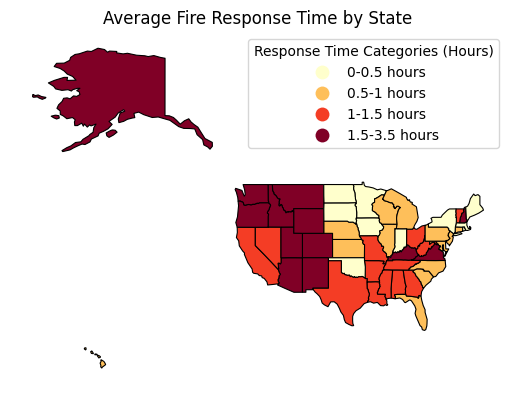

In [54]:
df3 = inform.copy()

df3 = df3[df3['Response Time'] >= 0]
upper_limit = df3['Response Time'].quantile(0.99)
df3 = df3[df3['Response Time'] <= upper_limit]

avg_state_response_time = df3.groupby('POO State')['Response Time'].mean().reset_index(name='Avg Response Time')
state_mapping = {
    "US-AK": "Alaska", "US-AL": "Alabama", "US-AR": "Arkansas", "US-AZ": "Arizona",
    "US-CA": "California", "US-CO": "Colorado", "US-CT": "Connecticut",
    "US-DC": "District of Columbia", "US-DE": "Delaware", "US-FL": "Florida",
    "US-GA": "Georgia", "US-GU": "Guam", "US-HI": "Hawaii", "US-IA": "Iowa",
    "US-ID": "Idaho", "US-IL": "Illinois", "US-IN": "Indiana", "US-KS": "Kansas",
    "US-KY": "Kentucky", "US-LA": "Louisiana", "US-MA": "Massachusetts",
    "US-MD": "Maryland", "US-ME": "Maine", "US-MI": "Michigan", "US-MN": "Minnesota",
    "US-MO": "Missouri", "US-MS": "Mississippi", "US-MT": "Montana",
    "US-NC": "North Carolina", "US-ND": "North Dakota", "US-NE": "Nebraska",
    "US-NH": "New Hampshire", "US-NJ": "New Jersey", "US-NM": "New Mexico",
    "US-NV": "Nevada", "US-NY": "New York", "US-OH": "Ohio", "US-OK": "Oklahoma",
    "US-OR": "Oregon", "US-PA": "Pennsylvania", "US-PR": "Puerto Rico",
    "US-RI": "Rhode Island", "US-SC": "South Carolina", "US-SD": "South Dakota",
    "US-TN": "Tennessee", "US-TX": "Texas", "US-UT": "Utah", "US-VA": "Virginia",
    "US-VI": "Virgin Islands", "US-VT": "Vermont", "US-WA": "Washington",
    "US-WI": "Wisconsin", "US-WV": "West Virginia", "US-WY": "Wyoming"
}
avg_state_response_time['name'] = avg_state_response_time['POO State'].map(state_mapping)
shapefile_path = '/content/drive/MyDrive/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp'
us_map = gpd.read_file(shapefile_path)
us_map = us_map[us_map['admin'] == 'United States of America']
us_map = us_map[['geometry', 'name']]
map_data = us_map.merge(avg_state_response_time, on='name', how='left')
map_data['Avg Response Time'] = map_data['Avg Response Time'].fillna(0)
bins = [0, 0.5, 1,1.5, 3.5]
labels = ['0-0.5 hours', '0.5-1 hours ', '1-1.5 hours', '1.5-3.5 hours']
map_data['Category'] = pd.cut(map_data['Avg Response Time'], bins=bins, labels=labels, include_lowest=True)
plt.figure(figsize=(4, 3))
map_data.plot(
    column='Category',
    cmap='YlOrRd',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'title': "Response Time Categories (Hours)"}
)
plt.title('Average Fire Response Time by State', fontsize=12)
plt.axis('off')
plt.show()

### **Visualization 2 - Incident Size Trends by Season from 1990 to 2023**

This line graph visualizes the differences in fire incident sizes by season. From our results, it is safe to conclude that summer has the largest wildfires, while winter has the smallest ones.

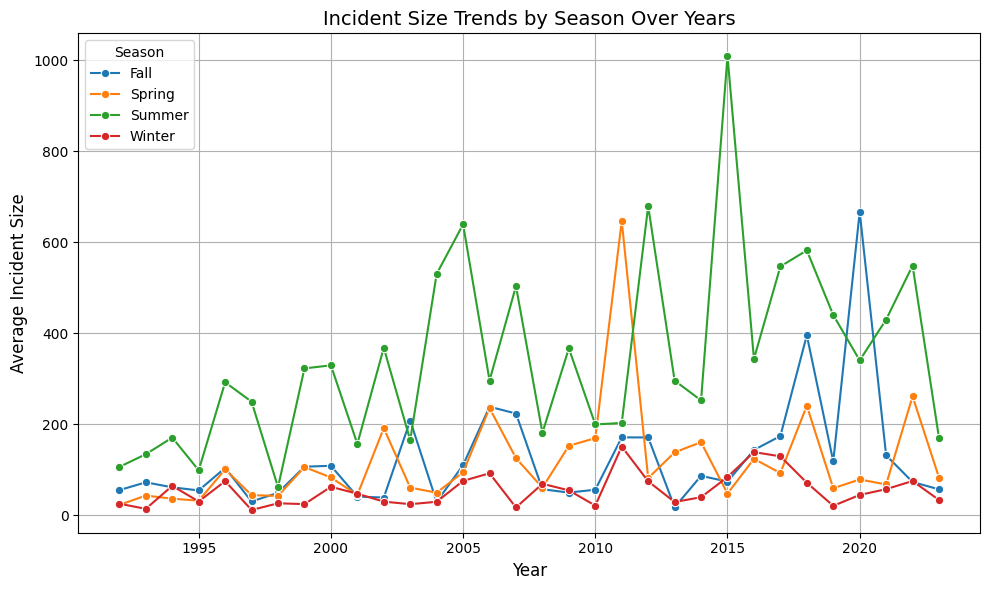

In [55]:
df4 = inform.copy()

df4['Year'] = df4['Fire Discovery Date Time'].dt.year
df4 = df4[(df4['Year'] >= 1990) & (df4['Year'] < 2024)]
seasonal_trends = df4.groupby(['Year', 'Season'])['Incident Size'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Incident Size', hue='Season', data=seasonal_trends, marker='o')
plt.title('Incident Size Trends by Season Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Incident Size', fontsize=12)
plt.legend(title='Season', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Visualization 3 - Number of Fires by Cause and Season**
#### This grouped bar plot represents the number of fires (log scaled) for each documented fire cause. It is categorized by the four seasons Fall, Spring, Summer, and Winter, and contains various causes including Natural, Smoking, Unlawful, etc.

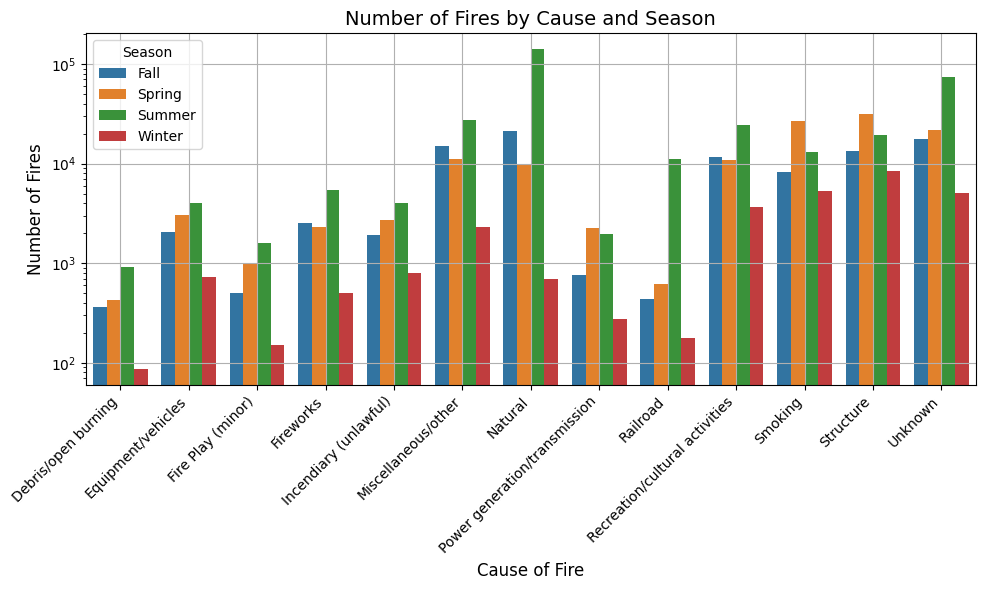

In [56]:
fire_counts = inform.groupby(['Fire Cause General', 'Season']).size().reset_index(name='Number of Fires')
plt.figure(figsize=(10, 6))
sns.barplot(x='Fire Cause General', y='Number of Fires', hue='Season', data=fire_counts)
plt.yscale('log')
plt.title('Number of Fires by Cause and Season', fontsize=14)
plt.xlabel('Cause of Fire', fontsize=12)
plt.ylabel('Number of Fires', fontsize=12)
plt.legend(title='Season', loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)



---


## **Machine Learning Model 1**

### After integrating the weather data and taking the required subset (after extensive analysis) with good causal relationship and required attributes, this dataset has been created.

```
# This is formatted as code
```



In [77]:
final_model_data=pd.read_csv('/content/final_model_data.csv')

In [78]:
df_fi = pd.merge(final_model_data, inform, left_on='object_id', right_on='OBJECTID', how='inner')

### Converting size of fire into range bins given and classifying them as small and large.

In [80]:

bins = [40, 200, 70000]
labels = ['small', 'large']

df_fi['size_category'] = pd.cut(df_fi['Incident Size'], bins=bins, labels=labels, right=False)
df_fi['size_category'].value_counts()

,count
size_category,
small,9047
large,8060


### Columns used for traning our model

In [60]:
columns=['avg_temperature_2m_max', 'avg_temperature_2m_min',
       'avg_temperature_2m_mean', 'avg_precipitation_sum', 'avg_snowfall_sum',
       'avg_wind_speed_10m_max', 'avg_wind_gusts_10m_max',
       'avg_relative_humidity_2m', 'avg_pressure_msl', 'avg_surface_pressure',
       'avg_soil_temperature_0_to_7cm', 'avg_soil_moisture_0_to_7cm','GACC', 'Incident Type Category','POO Landowner Kind',
       'Predominant Fuel Group','Fire Cause General', 'Season',
       'size_category', 'Response Time', 'Fire Duration (hrs)']
df_fi=df_fi[columns]

In [61]:
df_fi.dropna(inplace=True)
df_fi = df_fi[~df_fi['Fire Cause General'].isin(['Unknown'])]

### Scaling the enviromental variables so that they are not affected by scales of attribute

In [62]:
col_to_scale=['avg_temperature_2m_max', 'avg_temperature_2m_min',
        'avg_temperature_2m_mean', 'avg_precipitation_sum', 'avg_snowfall_sum',
       'avg_wind_speed_10m_max', 'avg_wind_gusts_10m_max',
        'avg_relative_humidity_2m', 'avg_pressure_msl', 'avg_surface_pressure',
        'avg_soil_temperature_0_to_7cm', 'avg_soil_moisture_0_to_7cm','Response Time', 'Fire Duration (hrs)']
scaler = MinMaxScaler()
df_fi[col_to_scale] = scaler.fit_transform(df_fi[col_to_scale])

### Encoding the size category to proper labels

In [63]:
label_encoder = LabelEncoder()
df_fi['size_category'] = label_encoder.fit_transform(df_fi['size_category'])
classlabel = {i: label for i, label in enumerate(label_encoder.classes_)}

### Training a baseline classifier model and obtaining the evalution matrix

In [64]:
np.random.seed(23)
X = df_fi.drop(columns=['size_category'])
y = df_fi['size_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
class Random_Classifier:
    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.random.choice(np.unique(y), size=len(X))

rand = Random_Classifier()

rand.fit(X_train, y_train)

y_pred = rand.predict(X_test)
class_names = [classlabel[i] for i in range(len(classlabel))]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       large       0.48      0.51      0.50      2338
       small       0.52      0.50      0.51      2536

    accuracy                           0.50      4874
   macro avg       0.50      0.50      0.50      4874
weighted avg       0.50      0.50      0.50      4874



### Training a random forest classifier model using n_estimators = 200 and train test split of 30%

In [65]:
df_fi = pd.get_dummies(df_fi, columns=['GACC','Incident Type Category', 'POO Landowner Kind','Predominant Fuel Group', 'Fire Cause General', 'Season'])

X = df_fi.drop(columns=['size_category'])
y = df_fi['size_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred,target_names=class_names))

accuracy = rf_classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
               precision    recall  f1-score   support

       large       0.70      0.65      0.67      2314
       small       0.70      0.74      0.72      2560

    accuracy                           0.70      4874
   macro avg       0.70      0.70      0.70      4874
weighted avg       0.70      0.70      0.70      4874

Accuracy: 0.70


### Confusion matrix obtained of result

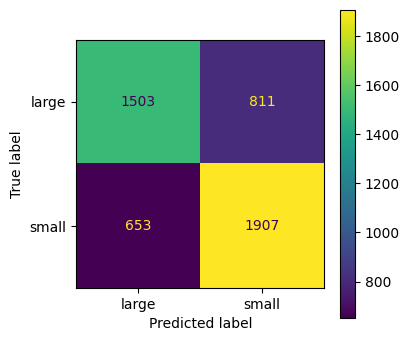

In [66]:
cm = ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test, display_labels=class_names)
cm.figure_.set_size_inches(4, 4)
plt.show()



---


## **Machine Learning Model 2**

In [68]:
datasetToBeRetrieved=pd.read_csv('/content/datasetToBeRetrieved.csv')

In [69]:
new_merge = pd.merge(datasetToBeRetrieved, inform, left_on='OBJECTID', right_on='OBJECTID', how='inner')
new_merge = new_merge[['OBJECTID', 'Incident Size', 'GACC','Initial Latitude','Initial Longitude', 'POO Landowner Kind','Predominant Fuel Group', 'Fire Cause General',
        'avg_temperature_2m_max','avg_precipitation_sum', 'avg_relative_humidity_2m']]

In [70]:
categoricalColumns = ['GACC', 'POO Landowner Kind', 'Predominant Fuel Group']
encodedDataset = pd.get_dummies(new_merge, columns=categoricalColumns, drop_first=True)

### Encoding the fire cause general


In [71]:
target = 'Fire Cause General'
label_encoder = LabelEncoder()
encodedDataset[target] = label_encoder.fit_transform(encodedDataset[target])
encodedToLabel = {i: label for i, label in enumerate(label_encoder.classes_)}

In [72]:
col_to_scale=['avg_temperature_2m_max', 'avg_precipitation_sum', 'avg_relative_humidity_2m']
scaler = MinMaxScaler()
encodedDataset[col_to_scale] = scaler.fit_transform(encodedDataset[col_to_scale])

In [73]:
X = encodedDataset.drop(columns=[target])
y = encodedDataset[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Using random forest classifier model to predict the specific cause of fire, test train split here is of 30% and classes are balanced using SMOTE.

In [74]:
classifier = RandomForestClassifier(n_estimators=100,random_state=42)
classifier.fit(X_resampled, y_resampled)
y_pred = classifier.predict(X_test)
class_names = [encodedToLabel[i] for i in range(len(encodedToLabel))]
class_report = classification_report(y_test, y_pred, target_names=class_names, digits=2)
print("Classification Report:")
print(class_report)

Classification Report:
                                precision    recall  f1-score   support

           Debris/open burning       0.43      0.48      0.45        82
            Equipment/vehicles       0.37      0.56      0.45       234
             Fire Play (minor)       0.29      0.19      0.23       116
                     Fireworks       0.17      0.16      0.17       350
         Incendiary (unlawful)       0.22      0.16      0.18       406
                       Natural       0.88      0.91      0.89     10456
 Power generation/transmission       0.05      0.02      0.03       123
                      Railroad       0.11      0.05      0.06       175
Recreation/cultural activities       0.54      0.50      0.52      2859
                       Smoking       0.46      0.40      0.42      1127
                     Structure       0.55      0.63      0.59      1683

                      accuracy                           0.73     17611
                     macro avg       0.

#**Key Takeaways**
1. The number of fires is influenced by the seasons.
2. Fire sizes vary across different seasons.
3. Vegetation types significantly impact the spread of fires.
4. Natural causes, such as lightning, are the most common triggers of wildfires.
